In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [17]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [19]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


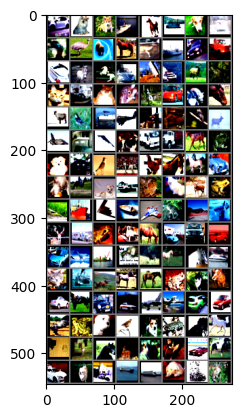

car   dog   dog   ship 


In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
# Improved CNN architecture for colored images with batch normalization and dropout
class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x

net = ImprovedNet().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


ImprovedNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), strid

In [24]:
# Training loop with GPU
for epoch in range(8):  # Increased epochs for better training
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    
    scheduler.step()
    print(f'Epoch {epoch + 1} completed, learning rate: {scheduler.get_last_lr()[0]}')

print('Finished Training')

PATH = './cifar_improved_net.pth'
torch.save(net.state_dict(), PATH)

[Epoch 1, Batch 100] loss: 0.897
[Epoch 1, Batch 200] loss: 0.879
[Epoch 1, Batch 300] loss: 0.868
Epoch 1 completed, learning rate: 0.001
[Epoch 2, Batch 100] loss: 0.836
[Epoch 2, Batch 200] loss: 0.813
[Epoch 2, Batch 300] loss: 0.795
Epoch 2 completed, learning rate: 0.001
[Epoch 3, Batch 100] loss: 0.773
[Epoch 3, Batch 200] loss: 0.763
[Epoch 3, Batch 300] loss: 0.766
Epoch 3 completed, learning rate: 0.001
[Epoch 4, Batch 100] loss: 0.731
[Epoch 4, Batch 200] loss: 0.710
[Epoch 4, Batch 300] loss: 0.744
Epoch 4 completed, learning rate: 0.001
[Epoch 5, Batch 100] loss: 0.686
[Epoch 5, Batch 200] loss: 0.692
[Epoch 5, Batch 300] loss: 0.696
Epoch 5 completed, learning rate: 0.001
[Epoch 6, Batch 100] loss: 0.667
[Epoch 6, Batch 200] loss: 0.660
[Epoch 6, Batch 300] loss: 0.659
Epoch 6 completed, learning rate: 0.0005
[Epoch 7, Batch 100] loss: 0.609
[Epoch 7, Batch 200] loss: 0.587
[Epoch 7, Batch 300] loss: 0.581
Epoch 7 completed, learning rate: 0.0005
[Epoch 8, Batch 100] loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


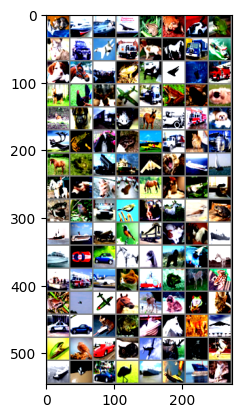

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  ship 

Comprehensive Evaluation Metrics:
Accuracy: 85.62%
Precision: 0.8559
Recall: 0.8562
F1 Score: 0.8542

Per-class Accuracy:
Accuracy for class: plane is 87.0 %
Accuracy for class: car   is 95.1 %
Accuracy for class: bird  is 72.1 %
Accuracy for class: cat   is 64.4 %
Accuracy for class: deer  is 85.9 %
Accuracy for class: dog   is 83.2 %
Accuracy for class: frog  is 90.5 %
Accuracy for class: horse is 91.1 %
Accuracy for class: ship  is 93.0 %
Accuracy for class: truck is 93.9 %


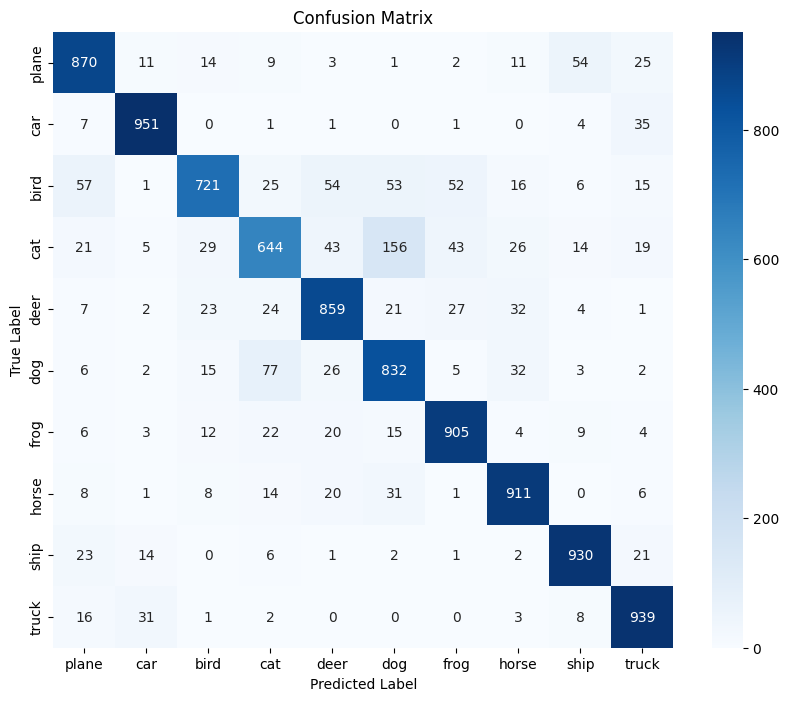

In [25]:
# Evaluation with comprehensive metrics
net = ImprovedNet().to(device)
net.load_state_dict(torch.load(PATH, weights_only=True))
net.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

# Comprehensive evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f'\nComprehensive Evaluation Metrics:')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Per-class accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('\nPer-class Accuracy:')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
